In [1]:
# Import necessary libraries for SVM model training
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import joblib
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load and combine all CSV files for SVM training
def load_coal_mine_dataset():
    """Load all CSV files from the Dataset folder and combine them"""
    
    # Get all CSV files in the Dataset folder
    csv_files = glob.glob('Dataset/batch*.csv')
    print(f"Found {len(csv_files)} CSV files: {sorted(csv_files)}")
    
    # List to store all dataframes
    dataframes = []
    
    # Load each CSV file
    for file in csv_files:
        df = pd.read_csv(file)
        print(f"Loaded {file}: {df.shape}")
        dataframes.append(df)
    
    # Combine all dataframes
    combined_df = pd.concat(dataframes, ignore_index=True)
    print(f"\nCombined dataset shape: {combined_df.shape}")
    print(f"Features: {combined_df.columns.tolist()[:5]}... (showing first 5)")
    
    return combined_df, csv_files

# Load the dataset
df, csv_files = load_coal_mine_dataset()

Found 10 CSV files: ['Dataset\\batch1.csv', 'Dataset\\batch10.csv', 'Dataset\\batch2.csv', 'Dataset\\batch3.csv', 'Dataset\\batch4.csv', 'Dataset\\batch5.csv', 'Dataset\\batch6.csv', 'Dataset\\batch7.csv', 'Dataset\\batch8.csv', 'Dataset\\batch9.csv']
Loaded Dataset\batch1.csv: (445, 129)
Loaded Dataset\batch10.csv: (3600, 129)
Loaded Dataset\batch2.csv: (1244, 129)
Loaded Dataset\batch3.csv: (1586, 129)
Loaded Dataset\batch4.csv: (161, 129)
Loaded Dataset\batch5.csv: (197, 129)
Loaded Dataset\batch6.csv: (2300, 129)
Loaded Dataset\batch7.csv: (3613, 129)
Loaded Dataset\batch8.csv: (294, 129)
Loaded Dataset\batch9.csv: (470, 129)

Combined dataset shape: (13910, 129)
Features: ['label', 'feature_1', 'feature_2', 'feature_3', 'feature_4']... (showing first 5)


In [3]:
# Explore the dataset for SVM
print("=== Dataset Overview for SVM ===")
print(f"Shape: {df.shape}")
print(f"Total samples: {len(df)}")
print(f"Features: {len(df.columns) - 1} (excluding label)")

print(f"\n=== Label Distribution ===")
label_counts = df['label'].value_counts().sort_index()
print(label_counts)
print(f"Label percentages:")
for label, count in label_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  Class {label}: {percentage:.2f}%")

# Check if dataset is balanced
balance_ratio = label_counts.min() / label_counts.max()
print(f"\nClass balance ratio (min/max): {balance_ratio:.3f}")
if balance_ratio < 0.5:
    print("⚠️  Dataset appears imbalanced - will use balanced SVM")
else:
    print("✓ Dataset appears relatively balanced")

print(f"\n=== Data Quality Check ===")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")

print(f"\n=== Feature Statistics (sample) ===")
feature_cols = [col for col in df.columns if col.startswith('feature_')]
print(f"Number of features: {len(feature_cols)}")
sample_stats = df[feature_cols[:5]].describe()
print("First 5 features statistics:")
print(sample_stats)

=== Dataset Overview for SVM ===
Shape: (13910, 129)
Total samples: 13910
Features: 128 (excluding label)

=== Label Distribution ===
label
1    2565
2    2926
3    1641
4    1936
5    3009
6    1833
Name: count, dtype: int64
Label percentages:
  Class 1: 18.44%
  Class 2: 21.04%
  Class 3: 11.80%
  Class 4: 13.92%
  Class 5: 21.63%
  Class 6: 13.18%

Class balance ratio (min/max): 0.545
✓ Dataset appears relatively balanced

=== Data Quality Check ===
Missing values: 0
Duplicate rows: 0

=== Feature Statistics (sample) ===
Number of features: 128
First 5 features statistics:
           feature_1     feature_2     feature_3     feature_4     feature_5
count   13910.000000  13910.000000  13910.000000  13910.000000  13910.000000
mean    50435.066174      6.638156     12.936688     18.743953     26.890695
std     69844.785952     13.486391     17.610061     24.899450     38.107685
min    -16757.598600      0.088287      0.000100      0.000100      0.000100
25%      6694.725950      2.2848

In [4]:
# Prepare data for SVM training
print("=== Preparing Data for SVM ===")

# Separate features and target
X = df.drop('label', axis=1)  # All features
y = df['label']  # Target variable

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Unique classes: {sorted(y.unique())}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"\nData Split:")
print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")

print(f"\nClass distribution in training set:")
train_dist = y_train.value_counts().sort_index()
for cls, count in train_dist.items():
    percentage = (count / len(y_train)) * 100
    print(f"  Class {cls}: {count} samples ({percentage:.2f}%)")

print(f"\nClass distribution in test set:")
test_dist = y_test.value_counts().sort_index()
for cls, count in test_dist.items():
    percentage = (count / len(y_test)) * 100
    print(f"  Class {cls}: {count} samples ({percentage:.2f}%)")

print(f"\nFeature ranges (important for SVM):")
print(f"  Min value: {X_train.min().min():.4f}")
print(f"  Max value: {X_train.max().max():.4f}")
print(f"  Mean: {X_train.mean().mean():.4f}")
print(f"  Std: {X_train.std().mean():.4f}")

=== Preparing Data for SVM ===
Features shape: (13910, 128)
Target shape: (13910,)
Unique classes: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]

Data Split:
Training set: (11128, 128)
Testing set: (2782, 128)

Class distribution in training set:
  Class 1: 2052 samples (18.44%)
  Class 2: 2341 samples (21.04%)
  Class 3: 1313 samples (11.80%)
  Class 4: 1549 samples (13.92%)
  Class 5: 2407 samples (21.63%)
  Class 6: 1466 samples (13.17%)

Class distribution in test set:
  Class 1: 513 samples (18.44%)
  Class 2: 585 samples (21.03%)
  Class 3: 328 samples (11.79%)
  Class 4: 387 samples (13.91%)
  Class 5: 602 samples (21.64%)
  Class 6: 367 samples (13.19%)

Feature ranges (important for SVM):
  Min value: -23660.6348
  Max value: 670687.3477
  Mean: 2793.3313
  Std: 2721.5572


In [5]:
# Feature scaling for SVM (critical for SVM performance)
print("=== Feature Scaling for SVM ===")

# SVM is sensitive to feature scaling, so we'll try different scalers
# StandardScaler: Mean=0, Std=1 (assumes normal distribution)
scaler_standard = StandardScaler()
X_train_standard = scaler_standard.fit_transform(X_train)
X_test_standard = scaler_standard.transform(X_test)

# RobustScaler: Uses median and IQR, less sensitive to outliers
scaler_robust = RobustScaler()
X_train_robust = scaler_robust.fit_transform(X_train)
X_test_robust = scaler_robust.transform(X_test)

print("Scaling comparison:")
print(f"Original data range: [{X_train.min().min():.3f}, {X_train.max().max():.3f}]")
print(f"Standard scaled range: [{X_train_standard.min():.3f}, {X_train_standard.max():.3f}]")
print(f"Robust scaled range: [{X_train_robust.min():.3f}, {X_train_robust.max():.3f}]")

print(f"\nStandard scaled stats:")
print(f"  Mean: {X_train_standard.mean():.6f}")
print(f"  Std: {X_train_standard.std():.6f}")

print(f"\nRobust scaled stats:")
print(f"  Median: {np.median(X_train_robust):.6f}")
print(f"  IQR: {np.percentile(X_train_robust, 75) - np.percentile(X_train_robust, 25):.6f}")

# We'll primarily use StandardScaler as it's most common for SVM
X_train_scaled = X_train_standard
X_test_scaled = X_test_standard
selected_scaler = scaler_standard
scaler_name = "StandardScaler"

print(f"\nSelected scaler: {scaler_name}")

=== Feature Scaling for SVM ===
Scaling comparison:
Original data range: [-23660.635, 670687.348]
Standard scaled range: [-102.315, 105.483]
Robust scaled range: [-470.277, 25637.300]

Standard scaled stats:
  Mean: 0.000000
  Std: 1.000000

Robust scaled stats:
  Median: 0.000000
  IQR: 0.878086

Selected scaler: StandardScaler


In [6]:
# Train multiple SVM models with different kernels
print("=== Training SVM Models with Different Kernels ===")

# Check if we should use balanced class weights
class_weight = 'balanced' if balance_ratio < 0.7 else None
print(f"Using class_weight: {class_weight}")

# Define SVM models with different kernels
svm_models = {
    'Linear SVM': SVC(
        kernel='linear', 
        C=1.0, 
        class_weight=class_weight,
        random_state=42
    ),
    'RBF SVM': SVC(
        kernel='rbf', 
        C=1.0, 
        gamma='scale',
        class_weight=class_weight,
        random_state=42
    ),
    'Polynomial SVM': SVC(
        kernel='poly', 
        degree=3, 
        C=1.0,
        gamma='scale',
        class_weight=class_weight,
        random_state=42
    ),
    'Sigmoid SVM': SVC(
        kernel='sigmoid', 
        C=1.0,
        gamma='scale',
        class_weight=class_weight,
        random_state=42
    )
}

# Train models and store results
svm_results = {}

for model_name, model in svm_models.items():
    print(f"\nTraining {model_name}...")
    start_time = time.time()
    
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Calculate accuracies
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    # Cross-validation (using smaller cv for speed with SVM)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=3, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    training_time = time.time() - start_time
    
    # Store results
    svm_results[model_name] = {
        'model': model,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'y_test_pred': y_test_pred,
        'training_time': training_time
    }
    
    print(f"  Training Accuracy: {train_acc:.4f}")
    print(f"  Testing Accuracy: {test_acc:.4f}")
    print(f"  CV Score: {cv_mean:.4f} (+/- {cv_std * 2:.4f})")
    print(f"  Training Time: {training_time:.2f} seconds")
    print(f"  Support Vectors: {model.n_support_}")

print(f"\n=== SVM Models Comparison ===")
print(f"{'Model':<15} {'Test Acc':<10} {'CV Score':<15} {'Time(s)':<10}")
print("-" * 55)
for model_name, result in svm_results.items():
    print(f"{model_name:<15} {result['test_acc']:<10.4f} "
          f"{result['cv_mean']:.4f} ± {result['cv_std']:.3f}   {result['training_time']:<10.2f}")

=== Training SVM Models with Different Kernels ===
Using class_weight: balanced

Training Linear SVM...
  Training Accuracy: 0.9967
  Testing Accuracy: 0.9928
  CV Score: 0.9911 (+/- 0.0024)
  Training Time: 2.00 seconds
  Support Vectors: [ 87  89  76 169 127 115]

Training RBF SVM...
  Training Accuracy: 0.9880
  Testing Accuracy: 0.9885
  CV Score: 0.9780 (+/- 0.0024)
  Training Time: 8.91 seconds
  Support Vectors: [412 377 214 722 495 646]

Training Polynomial SVM...
  Training Accuracy: 0.8534
  Testing Accuracy: 0.8537
  CV Score: 0.8288 (+/- 0.0054)
  Training Time: 11.36 seconds
  Support Vectors: [1063  872  438 1409  981 1193]

Training Sigmoid SVM...
  Training Accuracy: 0.6088
  Testing Accuracy: 0.6071
  CV Score: 0.6129 (+/- 0.0067)
  Training Time: 11.76 seconds
  Support Vectors: [1298  984  531 1179 1150 1086]

=== SVM Models Comparison ===
Model           Test Acc   CV Score        Time(s)   
-------------------------------------------------------
Linear SVM      0.9

In [7]:
# Select best SVM model and perform hyperparameter tuning
print("=== Selecting Best SVM Model ===")

# Find the best model based on test accuracy
best_svm_name = max(svm_results.keys(), key=lambda k: svm_results[k]['test_acc'])
best_svm_result = svm_results[best_svm_name]

print(f"Best performing SVM: {best_svm_name}")
print(f"Test Accuracy: {best_svm_result['test_acc']:.4f}")
print(f"CV Score: {best_svm_result['cv_mean']:.4f} (+/- {best_svm_result['cv_std'] * 2:.4f})")
print(f"Training Time: {best_svm_result['training_time']:.2f} seconds")

# Hyperparameter tuning for the best model (simplified grid for speed)
print(f"\n=== Hyperparameter Tuning for {best_svm_name} ===")

if best_svm_name == 'Linear SVM':
    param_grid = {
        'C': [0.1, 1.0, 10.0]
    }
elif best_svm_name == 'RBF SVM':
    param_grid = {
        'C': [0.1, 1.0, 10.0],
        'gamma': ['scale', 0.01, 0.1]
    }
elif best_svm_name == 'Polynomial SVM':
    param_grid = {
        'C': [0.1, 1.0, 10.0],
        'degree': [2, 3, 4],
        'gamma': ['scale', 0.01]
    }
else:  # Sigmoid SVM
    param_grid = {
        'C': [0.1, 1.0, 10.0],
        'gamma': ['scale', 0.01, 0.1]
    }

print(f"Parameter grid: {param_grid}")
print("Starting Grid Search (this may take a while)...")

# Create a fresh model for grid search
base_model = type(best_svm_result['model'])(
    kernel=best_svm_result['model'].kernel,
    class_weight=class_weight,
    random_state=42
)

# Perform grid search
grid_search = GridSearchCV(
    base_model,
    param_grid,
    cv=3,  # Reduced CV for speed
    scoring='accuracy',
    n_jobs=-1,  # Use all available cores
    verbose=1
)

start_time = time.time()
grid_search.fit(X_train_scaled, y_train)
grid_search_time = time.time() - start_time

# Get the best model
best_tuned_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"\nGrid Search completed in {grid_search_time:.2f} seconds")
print(f"Best parameters: {best_params}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

# Evaluate tuned model
y_train_pred_tuned = best_tuned_model.predict(X_train_scaled)
y_test_pred_tuned = best_tuned_model.predict(X_test_scaled)

train_acc_tuned = accuracy_score(y_train, y_train_pred_tuned)
test_acc_tuned = accuracy_score(y_test, y_test_pred_tuned)

print(f"\nTuned model performance:")
print(f"Training Accuracy: {train_acc_tuned:.4f}")
print(f"Testing Accuracy: {test_acc_tuned:.4f}")
print(f"Improvement: {test_acc_tuned - best_svm_result['test_acc']:.4f}")

=== Selecting Best SVM Model ===
Best performing SVM: Linear SVM
Test Accuracy: 0.9928
CV Score: 0.9911 (+/- 0.0024)
Training Time: 2.00 seconds

=== Hyperparameter Tuning for Linear SVM ===
Parameter grid: {'C': [0.1, 1.0, 10.0]}
Starting Grid Search (this may take a while)...
Fitting 3 folds for each of 3 candidates, totalling 9 fits

Grid Search completed in 6.16 seconds
Best parameters: {'C': 10.0}
Best CV score: 0.9914

Tuned model performance:
Training Accuracy: 0.9980
Testing Accuracy: 0.9942
Improvement: 0.0014


In [8]:
# Detailed evaluation of the best tuned SVM model
print("=== Detailed Evaluation of Best Tuned SVM ===")

# Use the better performing model (original vs tuned)
if test_acc_tuned > best_svm_result['test_acc']:
    final_model = best_tuned_model
    final_predictions = y_test_pred_tuned
    final_accuracy = test_acc_tuned
    model_type = f"{best_svm_name} (Tuned)"
    print(f"Using tuned model with {final_accuracy:.4f} accuracy")
else:
    final_model = best_svm_result['model']
    final_predictions = best_svm_result['y_test_pred']
    final_accuracy = best_svm_result['test_acc']
    model_type = f"{best_svm_name} (Original)"
    print(f"Using original model with {final_accuracy:.4f} accuracy")

print(f"\nFinal Model: {model_type}")
print(f"Final Test Accuracy: {final_accuracy:.4f}")

# Classification report
print(f"\n=== Classification Report ===")
print(classification_report(y_test, final_predictions, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test, final_predictions)
print(f"\n=== Confusion Matrix ===")
print(cm)

# Class-wise accuracy
print(f"\n=== Class-wise Performance ===")
unique_classes = sorted(y.unique())
for i, class_label in enumerate(unique_classes):
    class_mask = (y_test == class_label)
    if class_mask.sum() > 0:  # Check if class exists in test set
        class_predictions = final_predictions[class_mask]
        class_actual = y_test[class_mask]
        class_accuracy = accuracy_score(class_actual, class_predictions)
        print(f"  Class {class_label}: {class_accuracy:.4f} ({class_mask.sum()} samples)")

# Model parameters
print(f"\n=== Final Model Parameters ===")
print(f"Kernel: {final_model.kernel}")
print(f"C (Regularization): {final_model.C}")
if hasattr(final_model, 'gamma'):
    print(f"Gamma: {final_model.gamma}")
if hasattr(final_model, 'degree'):
    print(f"Degree: {final_model.degree}")
print(f"Class weight: {final_model.class_weight}")
print(f"Number of support vectors: {final_model.n_support_}")
print(f"Total support vectors: {final_model.support_vectors_.shape[0]}")

=== Detailed Evaluation of Best Tuned SVM ===
Using tuned model with 0.9942 accuracy

Final Model: Linear SVM (Tuned)
Final Test Accuracy: 0.9942

=== Classification Report ===
              precision    recall  f1-score   support

           1       1.00      0.99      0.99       513
           2       0.99      1.00      1.00       585
           3       0.99      0.99      0.99       328
           4       0.98      1.00      0.99       387
           5       0.99      0.99      0.99       602
           6       1.00      1.00      1.00       367

    accuracy                           0.99      2782
   macro avg       0.99      0.99      0.99      2782
weighted avg       0.99      0.99      0.99      2782


=== Confusion Matrix ===
[[508   2   0   3   0   0]
 [  1 583   0   1   0   0]
 [  0   0 324   0   4   0]
 [  0   0   0 387   0   0]
 [  0   1   2   2 597   0]
 [  0   0   0   0   0 367]]

=== Class-wise Performance ===
  Class 1: 0.9903 (513 samples)
  Class 2: 0.9966 (585 samp

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- feature_10
- feature_100
- feature_101
- feature_102
- feature_103
- ...


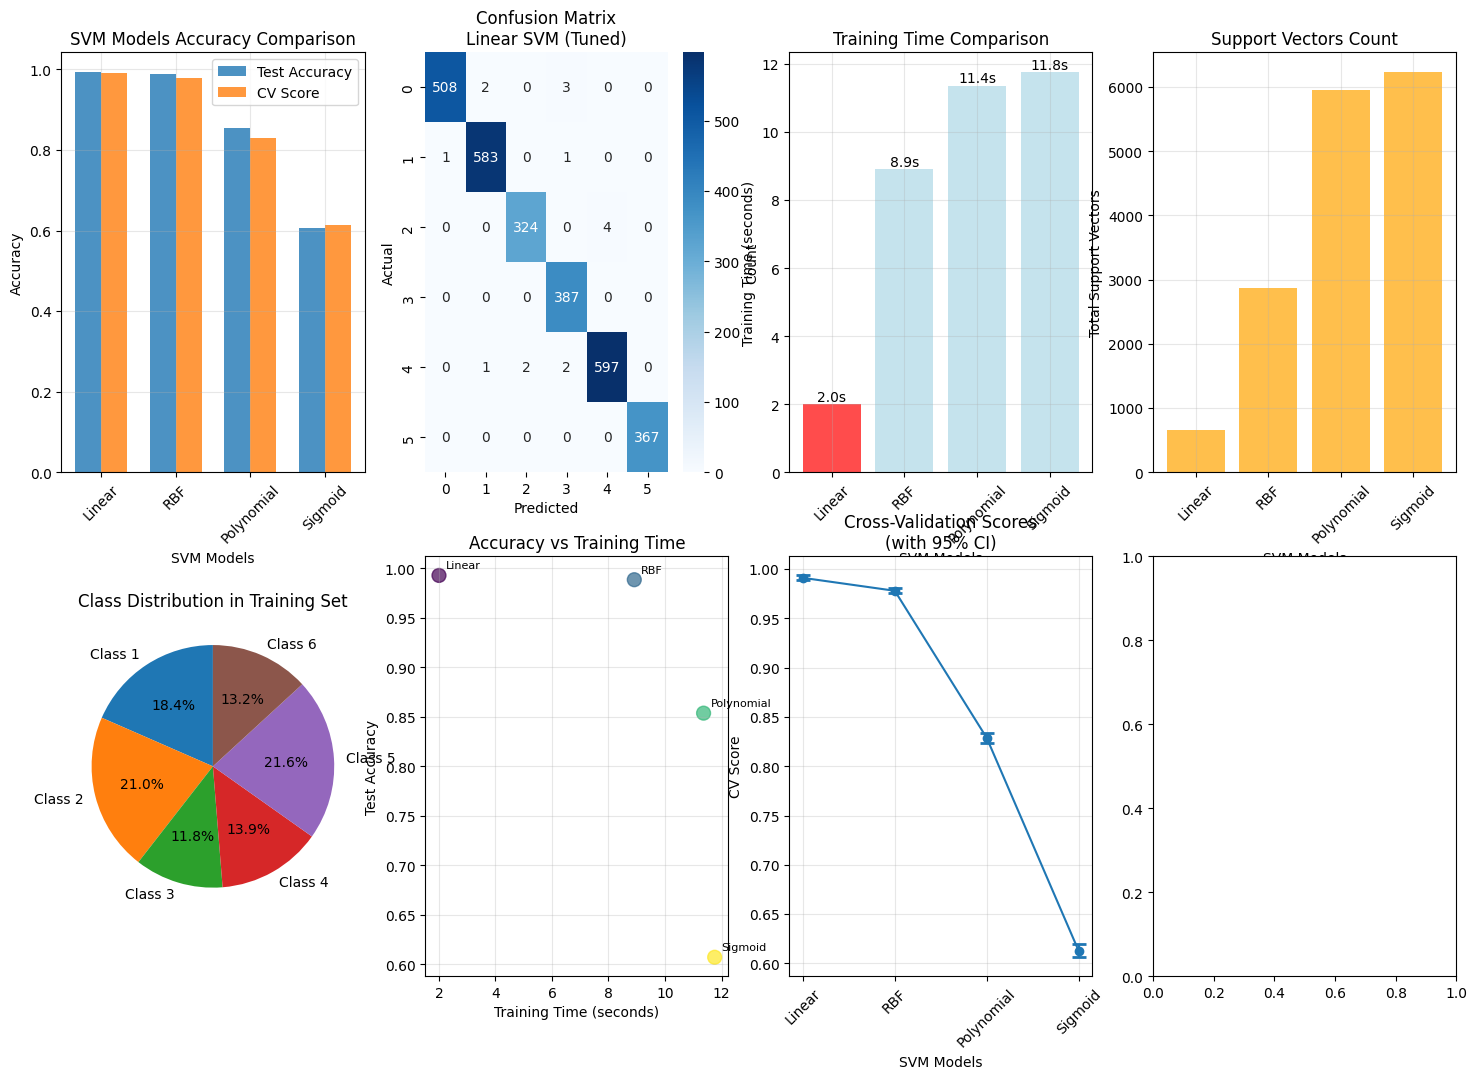

In [9]:
# Comprehensive visualization of SVM results
plt.figure(figsize=(18, 12))

# Plot 1: Model Comparison
plt.subplot(2, 4, 1)
model_names = list(svm_results.keys())
test_accuracies = [svm_results[name]['test_acc'] for name in model_names]
cv_scores = [svm_results[name]['cv_mean'] for name in model_names]
training_times = [svm_results[name]['training_time'] for name in model_names]

x = range(len(model_names))
width = 0.35
plt.bar([i - width/2 for i in x], test_accuracies, width, label='Test Accuracy', alpha=0.8)
plt.bar([i + width/2 for i in x], cv_scores, width, label='CV Score', alpha=0.8)
plt.xlabel('SVM Models')
plt.ylabel('Accuracy')
plt.title('SVM Models Accuracy Comparison')
plt.xticks(x, [name.replace(' SVM', '') for name in model_names], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Confusion Matrix
plt.subplot(2, 4, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix\n{model_type}')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot 3: Training Time Comparison
plt.subplot(2, 4, 3)
colors = ['red' if name == best_svm_name else 'lightblue' for name in model_names]
bars = plt.bar(range(len(model_names)), training_times, color=colors, alpha=0.7)
plt.xlabel('SVM Models')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time Comparison')
plt.xticks(range(len(model_names)), [name.replace(' SVM', '') for name in model_names], rotation=45)
plt.grid(True, alpha=0.3)
# Add value labels on bars
for i, (bar, time_val) in enumerate(zip(bars, training_times)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{time_val:.1f}s', ha='center', va='bottom')

# Plot 4: Support Vectors Count
plt.subplot(2, 4, 4)
sv_counts = [svm_results[name]['model'].n_support_ for name in model_names]
sv_totals = [sum(sv) for sv in sv_counts]
plt.bar(range(len(model_names)), sv_totals, alpha=0.7, color='orange')
plt.xlabel('SVM Models')
plt.ylabel('Total Support Vectors')
plt.title('Support Vectors Count')
plt.xticks(range(len(model_names)), [name.replace(' SVM', '') for name in model_names], rotation=45)
plt.grid(True, alpha=0.3)

# Plot 5: Class Distribution
plt.subplot(2, 4, 5)
class_counts = y_train.value_counts().sort_index()
plt.pie(class_counts.values, labels=[f'Class {c}' for c in class_counts.index], 
        autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution in Training Set')

# Plot 6: Performance vs Training Time
plt.subplot(2, 4, 6)
plt.scatter(training_times, test_accuracies, s=100, alpha=0.7, c=range(len(model_names)), cmap='viridis')
for i, name in enumerate(model_names):
    plt.annotate(name.replace(' SVM', ''), (training_times[i], test_accuracies[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)
plt.xlabel('Training Time (seconds)')
plt.ylabel('Test Accuracy')
plt.title('Accuracy vs Training Time')
plt.grid(True, alpha=0.3)

# Plot 7: CV Scores with Error Bars
plt.subplot(2, 4, 7)
cv_means = [svm_results[name]['cv_mean'] for name in model_names]
cv_stds = [svm_results[name]['cv_std'] for name in model_names]
plt.errorbar(range(len(model_names)), cv_means, yerr=[s * 2 for s in cv_stds], 
             fmt='o-', capsize=5, capthick=2)
plt.xlabel('SVM Models')
plt.ylabel('CV Score')
plt.title('Cross-Validation Scores\n(with 95% CI)')
plt.xticks(range(len(model_names)), [name.replace(' SVM', '') for name in model_names], rotation=45)
plt.grid(True, alpha=0.3)

# Plot 8: Feature Scaling Effect (sample features)
plt.subplot(2, 4, 8)
sample_features = X.iloc[:100, :5]  # Sample 100 rows, first 5 features
sample_scaled = selected_scaler.transform(sample_features)

plt.boxplot([sample_features.iloc[:, 0], sample_scaled[:, 0]], 
           labels=['Original', 'Scaled'])
plt.title('Feature Scaling Effect\n(Sample Feature)')
plt.ylabel('Feature Values')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# Save the best SVM model and related components
print("=== Saving Best SVM Model ===")

# Save the final best model
model_filename = f'coal_mine_svm_{best_svm_name.lower().replace(" ", "_")}_model.pkl'
joblib.dump(final_model, model_filename)
print(f"✓ Best SVM model saved as '{model_filename}'")

# Save the scaler (critical for SVM)
scaler_filename = f'coal_mine_svm_{scaler_name.lower()}.pkl'
joblib.dump(selected_scaler, scaler_filename)
print(f"✓ Feature scaler saved as '{scaler_filename}'")

# Save feature names
feature_names = X.columns.tolist()
joblib.dump(feature_names, 'coal_mine_svm_feature_names.pkl')
print(f"✓ Feature names saved as 'coal_mine_svm_feature_names.pkl'")

# Save comprehensive model summary
svm_summary = {
    'best_model_type': model_type,
    'best_model_name': best_svm_name,
    'final_test_accuracy': final_accuracy,
    'cv_score_mean': best_svm_result['cv_mean'],
    'cv_score_std': best_svm_result['cv_std'],
    'training_time': best_svm_result['training_time'],
    'num_features': len(feature_names),
    'num_samples': len(df),
    'num_classes': len(y.unique()),
    'class_distribution': y.value_counts().to_dict(),
    'support_vectors_count': final_model.n_support_.tolist(),
    'total_support_vectors': final_model.support_vectors_.shape[0],
    'kernel': final_model.kernel,
    'model_parameters': {
        'C': final_model.C,
        'kernel': final_model.kernel,
        'class_weight': str(final_model.class_weight)
    },
    'scaler_used': scaler_name,
    'hyperparameter_tuning': {
        'performed': True,
        'best_params': best_params if 'best_params' in locals() else 'Not tuned',
        'improvement': test_acc_tuned - best_svm_result['test_acc'] if 'test_acc_tuned' in locals() else 0
    },
    'all_models_performance': {
        name: {
            'test_accuracy': result['test_acc'],
            'cv_mean': result['cv_mean'],
            'training_time': result['training_time']
        }
        for name, result in svm_results.items()
    }
}

if hasattr(final_model, 'gamma'):
    svm_summary['model_parameters']['gamma'] = final_model.gamma
if hasattr(final_model, 'degree'):
    svm_summary['model_parameters']['degree'] = final_model.degree

joblib.dump(svm_summary, 'coal_mine_svm_model_summary.pkl')
print(f"✓ Comprehensive model summary saved as 'coal_mine_svm_model_summary.pkl'")

# Final summary
print(f"\n{'='*60}")
print(f"🎉 SVM MODEL TRAINING COMPLETED SUCCESSFULLY! 🎉")
print(f"{'='*60}")
print(f"📊 Dataset: Combined {len(csv_files)} CSV files")
print(f"📈 Total samples: {len(df):,}")
print(f"🔧 Features: {len(feature_names)}")
print(f"🏷️  Classes: {len(y.unique())}")
print(f"🏆 Best model: {model_type}")
print(f"🎯 Final accuracy: {final_accuracy:.4f}")
print(f"⏱️  Training time: {best_svm_result['training_time']:.2f} seconds")
print(f"🔍 Total support vectors: {final_model.support_vectors_.shape[0]}")
print(f"⚙️  Kernel: {final_model.kernel}")
print(f"📏 Feature scaling: {scaler_name}")
print(f"🔄 Models tested: {', '.join([name.replace(' SVM', '') for name in svm_results.keys()])}")
print(f"🎛️  Hyperparameter tuning: {'✓ Performed' if 'best_params' in locals() else '✗ Not performed'}")
print(f"\n💾 All model files saved and ready for deployment!")
print(f"{'='*60}")

=== Saving Best SVM Model ===
✓ Best SVM model saved as 'coal_mine_svm_linear_svm_model.pkl'
✓ Feature scaler saved as 'coal_mine_svm_standardscaler.pkl'
✓ Feature names saved as 'coal_mine_svm_feature_names.pkl'
✓ Comprehensive model summary saved as 'coal_mine_svm_model_summary.pkl'

🎉 SVM MODEL TRAINING COMPLETED SUCCESSFULLY! 🎉
📊 Dataset: Combined 10 CSV files
📈 Total samples: 13,910
🔧 Features: 128
🏷️  Classes: 6
🏆 Best model: Linear SVM (Tuned)
🎯 Final accuracy: 0.9942
⏱️  Training time: 2.00 seconds
🔍 Total support vectors: 434
⚙️  Kernel: linear
📏 Feature scaling: StandardScaler
🔄 Models tested: Linear, RBF, Polynomial, Sigmoid
🎛️  Hyperparameter tuning: ✓ Performed

💾 All model files saved and ready for deployment!
